# Imports

In [1]:
!pip install --upgrade --force-reinstall tensorflow-io
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install -U accelerate
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install -U git+https://github.com/huggingface/accelerate.git


SEED = 42
from Levenshtein import distance
from PIL import Image
from copy import deepcopy
from dataclasses import dataclass
from datasets import load_dataset, set_caching_enabled
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
from transformers import CLIPProcessor, CLIPModel
from typing import Dict, List, Optional, Tuple
import clip
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import requests
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import wandb
from transformers import (
    # Preprocessing / Common
    AutoTokenizer,
    AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments,
    Trainer,
    # Misc
    logging,
)

print("Torch version:", torch.__version__)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 26.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3hkdnvwj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3hkdnvwj
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) .

In [2]:
ANNOTATIONS_BASE_PATH = "/kaggle/input/vizwiz/data/Annotations/"
IMAGES_PATH = "/kaggle/input/vizwiz/data/Images/"
ANNOTATIONS_TRAIN_PATH = str(Path(ANNOTATIONS_BASE_PATH) / ".train.json")
ANNOTATIONS_VAL_PATH = str(Path(ANNOTATIONS_BASE_PATH) / "val.json")

# Data analysis

In [3]:
train = json.load(open("/kaggle/input/vizwiz/data/Annotations/train.json"))

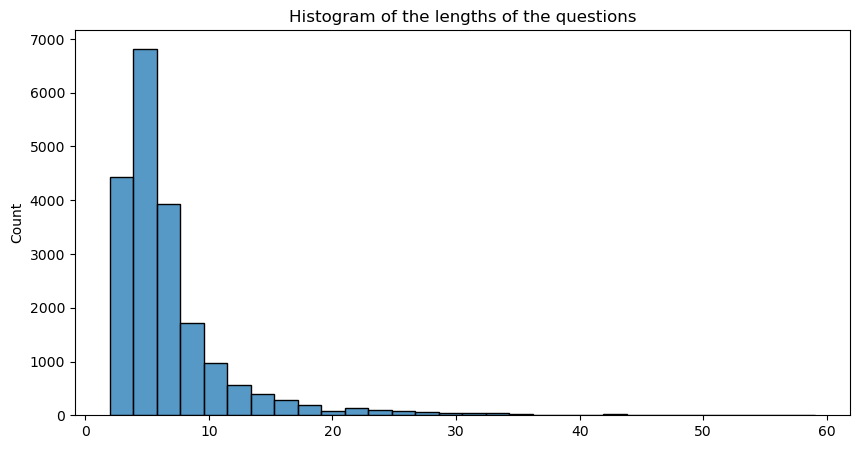

In [4]:
# plot histogram of the lengths of the questions
# get the lengths of the questions
lengths = [len(q['question'].split()) for q in train]
# plot the histogram
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=30)
plt.title('Histogram of the lengths of the questions')
plt.show()

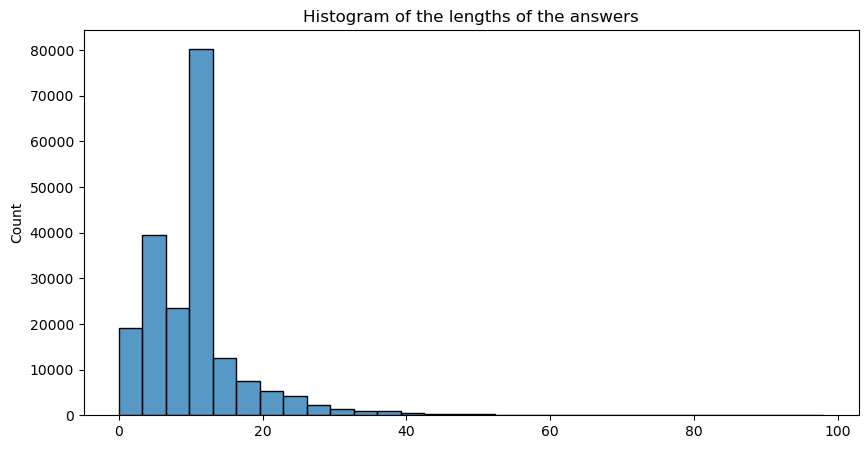

In [5]:
# plot the length of all the answers
# get the lengths of the answers
# answers > answer
answers = [q['answers'] for q in train]
lengths=[]
for ans in answers:
    for a in ans:
        lengths.append(len(a['answer']))
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=30)
plt.title('Histogram of the lengths of the answers')
plt.show()

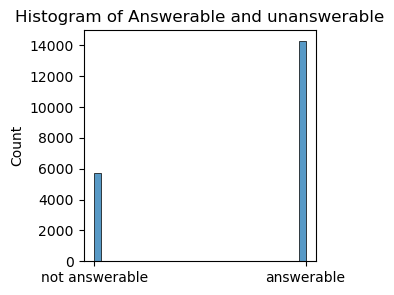

In [6]:
# plot the histogram if 1 then answerable else not answerable
# change the x axis from 0,1 to answerable, not answerable
lengths = [q['answerable'] for q in train]
plt.figure(figsize=(3, 3))
sns.histplot(lengths, bins=30)
plt.xticks([0, 1], ['not answerable', 'answerable'])
plt.title('Histogram of Answerable and unanswerable')
plt.show()

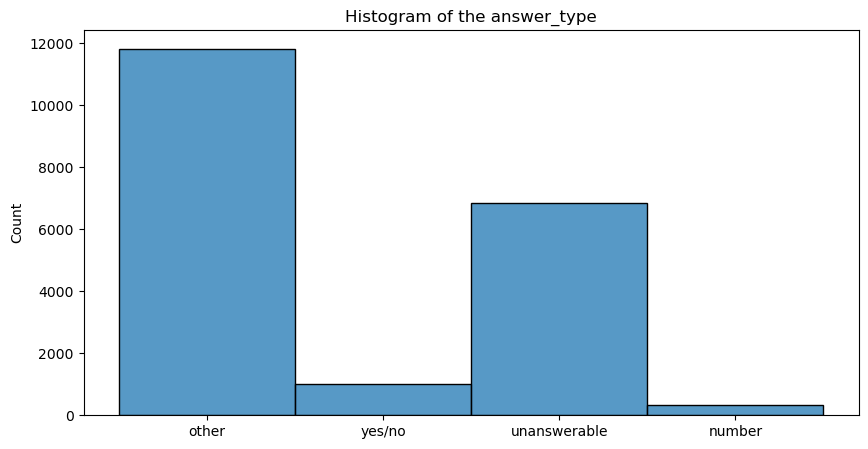

In [7]:
# plot histogram of the frequency of the answer type
answer_type = [q['answer_type'] for q in train]

plt.figure(figsize=(10, 5))
sns.histplot(answer_type, bins=30)
# plt.xticks([0, 1, 2], ['other', 'yes/no', 'number'])
plt.title('Histogram of the answer_type')
plt.show()

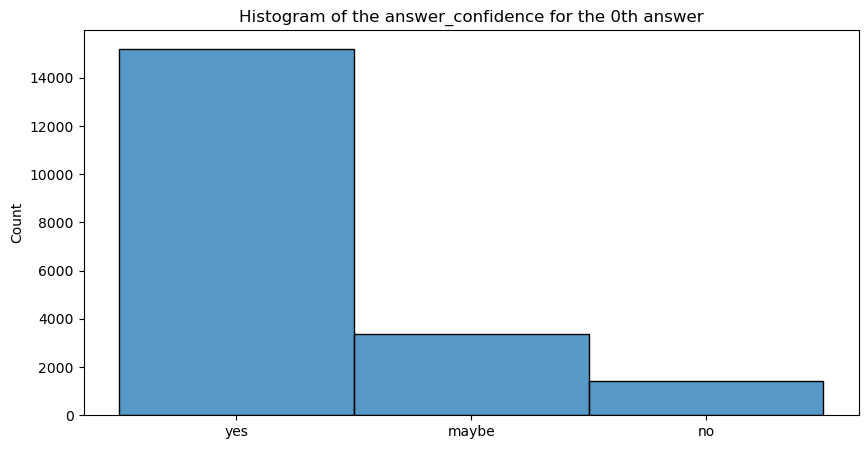

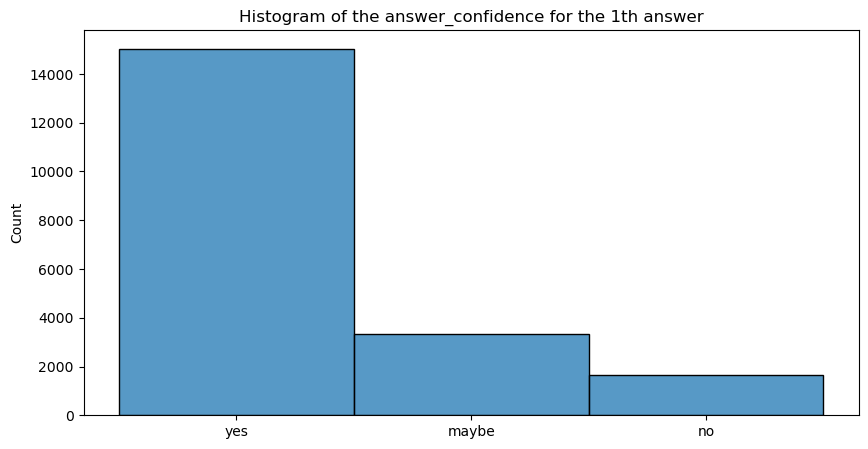

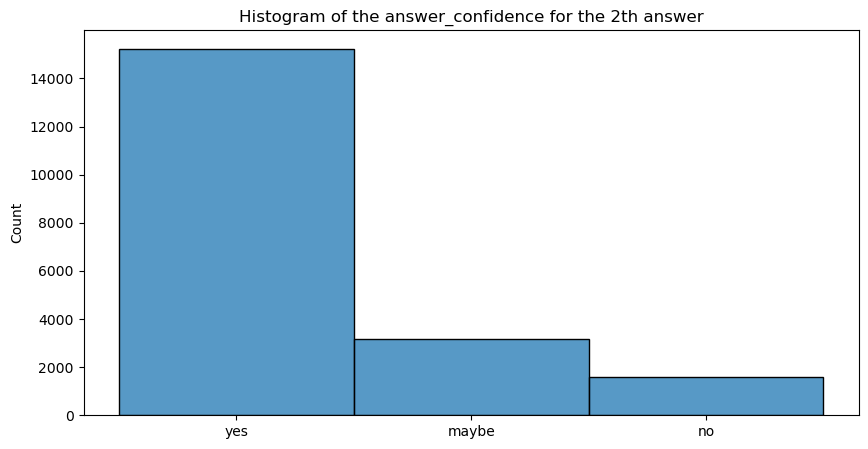

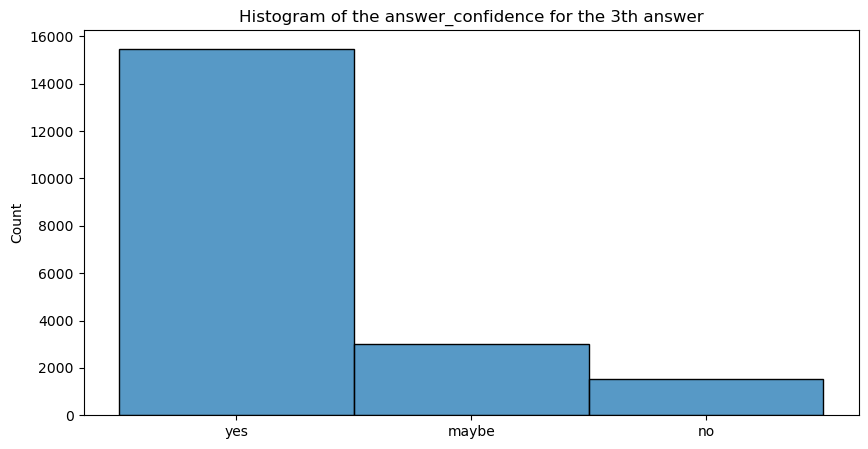

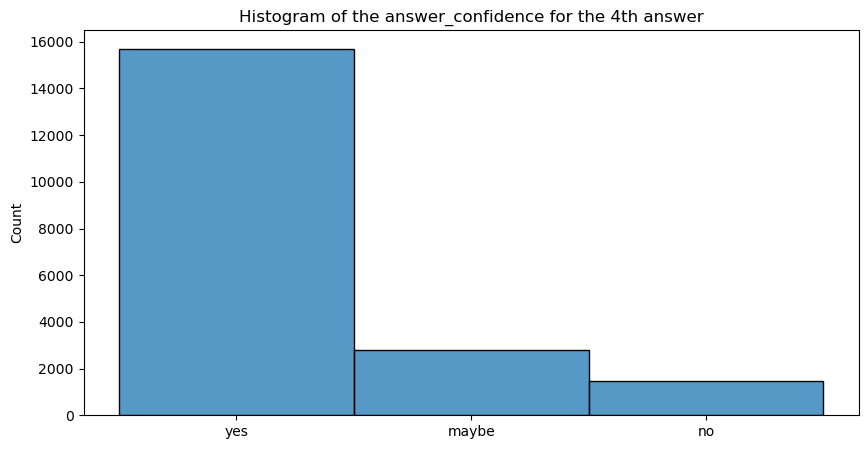

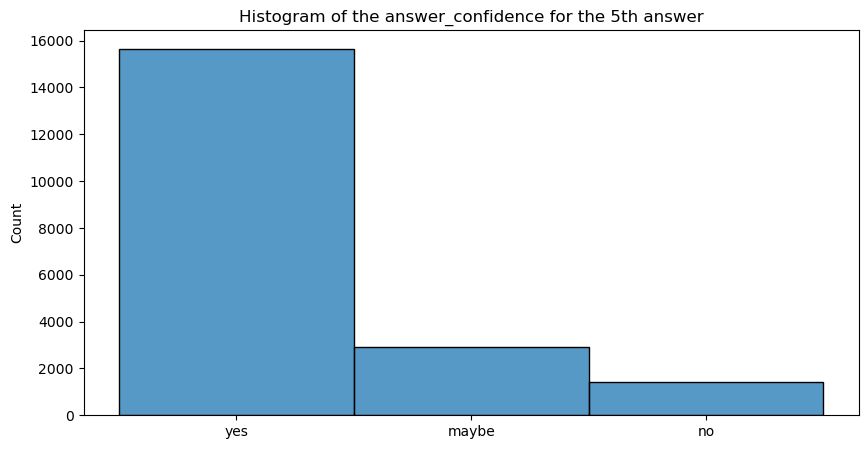

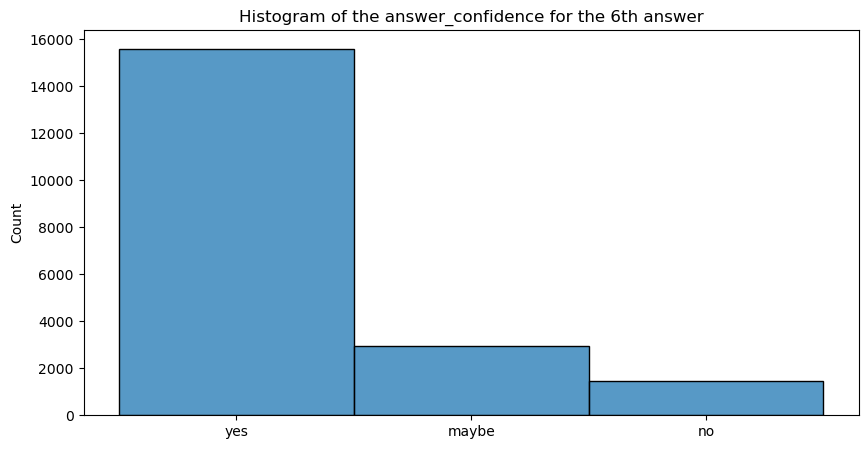

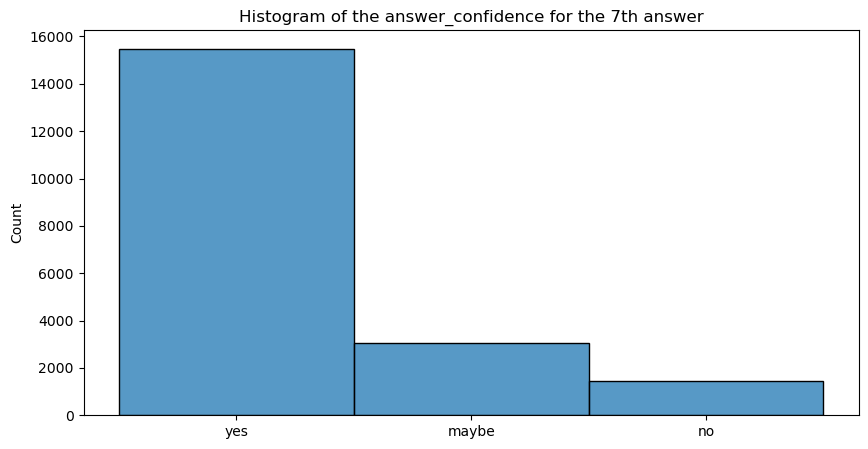

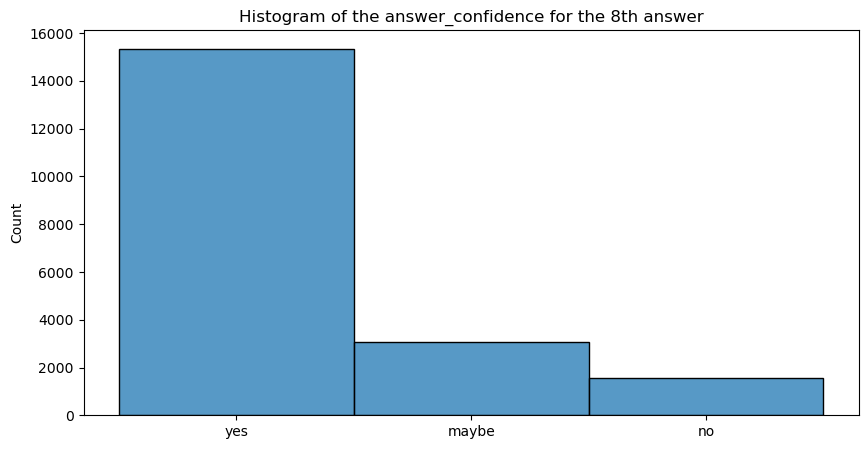

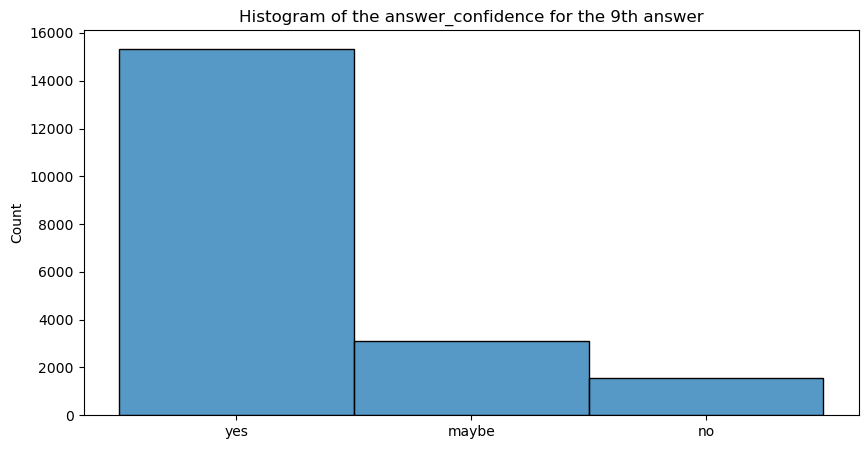

In [8]:
answers = [q['answers'] for q in train]
answer_confidence = [[a['answer_confidence'] for a in ans] for ans in answers]

for i in range(10):
    # get all the answer_confidence for the ith answer
    ith_answer_confidence = [ans[i] for ans in answer_confidence]
    # plot the histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(ith_answer_confidence, bins=30)
    plt.title(f'Histogram of the answer_confidence for the {i}th answer')
    plt.show()

# Building Vocabulary

In [3]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ["HF_HOME"] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

cuda
Tesla P100-PCIE-16GB


## Functions

In [10]:
def most_representative_word(words):
    min_distance = float('inf')
    representative_word = None
    for word1 in words:
        total_distance = 0
        for word2 in words:
            if word1 != word2:
                total_distance += distance(word1, word2)
        if total_distance < min_distance:
            min_distance = total_distance
            representative_word = word1
    return representative_word

In [11]:
# create a vocabulary for classification
# since each question has 10 answers be sure to select the most common answer if there's a tie in the answers for a question use the most representative word


def create_vocab():
    train = json.load(open("/kaggle/input/vizwiz/data/Annotations/train.json"))
    val = json.load(open("/kaggle/input/vizwiz/data/Annotations/val.json"))
    train_df = pd.DataFrame(train)
    # create a dataframe from the val data
    val_df = pd.DataFrame(val)
    # concatenate the train and val dataframes
    df = pd.concat([train_df, val_df], axis=0)
    # drop images column
    df = df.drop("image", axis=1)
    # drop answerable column
    df = df.drop("answerable", axis=1)
    # drop answer_type column
    df = df.drop("answer_type", axis=1)
    # drop question_type column
    df = df.drop("question", axis=1)
    # from answers select the most frequent answer per question
    for i in range(len(df)):
        # get the answers for the question
        answers_for_q = [a["answer"] for a in df["answers"].iloc[i]]
        # get the most common answer and if there's a tie select the most representative word
        answers_dict = {}
        for answer in answers_for_q:
            if answer == "":
                continue
            if answer in answers_dict:
                answers_dict[answer] += 1
            else:
                answers_dict[answer] = 1
        # get the most common answer and check if there's a tie
        most_common_answers = []
        for answer in answers_dict:
            if answers_dict[answer] == max(answers_dict.values()):
                most_common_answers.append(answer)
        # if there's a tie select the most representative word
        if len(most_common_answers) > 1:
            most_common_answer = most_representative_word(most_common_answers)
        else:
            most_common_answer = most_common_answers[0]
        # set the most common answer as the answer
        df['answers'].iloc[i] = most_common_answer
    # rename the answers column to answer
    df = df.rename(columns={"answers": "class_name"})
    # sort by frequent answers
    counts = pd.DataFrame(df["class_name"].value_counts())
    # add a column with the class index
    # counts['class_name'] = counts.index
    counts["class_index"] = range(len(counts))
    # create a class_mapping dataframe
    class_mapping = pd.DataFrame(
        {"answer": counts.index, "class_id": range(len(counts))}
    )
    # add empty key and len(class_mapping) as the value
    class_mapping = class_mapping.append(
        {"answer": "", "class_id": len(class_mapping)}, ignore_index=True
    )
    # save the class_mapping dataframe
    class_mapping.to_csv("class_mapping.csv", index=False)
    
    return class_mapping

In [12]:
class_mapping = create_vocab()
class_mapping.sample(5)

/tmp/ipykernel_23/3614865435.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



  class_mapping = class_mapping.append(


answer  class_id
3691  thin crust sausage      3691
969           poinsettia       969
2450    lego star wars 2      2450
3082        pink candles      3082
3727  grape raisin juice      3727

### Comment
We create a vocabulary from the most common answers in the dataset. In case of a tie, we use Levenshtein distance to break the tie.

## MultiModal Encoder 

In [13]:
class MultiModal_Encoder(nn.Module):
    def __init__(self):
        super(MultiModal_Encoder, self).__init__()
        self.model, self.preprocess = clip.load("ViT-L/14@336px", device="cuda")

    def forward(self, image, question, device="cuda"):
        image = self.preprocess(image).unsqueeze(0).to(device)
        # preprocess question
        text = clip.tokenize(question).to(device)
        # get image features
        with torch.no_grad():
            image_features = self.model.encode_image(image)
        # get text features
        with torch.no_grad():
            text_features = self.model.encode_text(text)
        return image_features, text_features

## DataSet Class

In [14]:
class VizWizDataset(Dataset):
    def __init__(self, df, y_train, image_path):
        self.df = df
        self.df_copy = df
        self.answers = get_answers(self.df_copy)
        self.answerable = y_train["answerable"].values
        self.answer_type = y_train["answer_type"].values
        self.image_paths = image_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths + self.df.iloc[idx]["image"]
        img = Image.open(img_path)
        question = self.df.iloc[idx]["question"]
        answer = self.answers[idx]
        answerable = self.answerable[idx]
        answer_type = self.answer_type[idx]
        # transform image to 336 x 336 image
        img = TF.pil_to_tensor(TF.resize(img, (336, 336)))

        return img, question, answer, answerable, answer_type

In [15]:
def seed_worker(worker_id):
    worker_seed = SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

## Training

In [ ]:
train_dataset = VizWizDataset(X_train,y_train, IMAGES_PATH)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g,
)
val_dataset = VizWizDataset(X_val,y_val, IMAGES_PATH)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g,
)
test_dataset = VizWizDataset(X_test,y_test, IMAGES_PATH)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g,
)

In [ ]:
model_multi = MultiModal_Encoder()

In [ ]:
os.makedirs("/kaggle/working/my_dataset", exist_ok=True)

In [17]:
# test dataloader to check if the data is loaded correctly
# select a random sample from dataloader
train_img_encoded = torch.empty((len(train_dataloader) * 4, 768))
train_txt_encoded = torch.empty((len(train_dataloader) * 4, 768))
train_answers = []
train_answerable = torch.empty((len(train_dataloader) * 4, 1))
train_answer_type = []
for batch_idx, (img, question,answer,answerable,answer_type) in enumerate(train_dataloader):
    if (batch_idx) % 1000 == 0:
        print(f"{batch_idx}/{len(train_dataloader)}")
    img = to_pil_image(img[0])
    question = question[0]

    for i, angle in enumerate(range(0, 360, 90)):
        # rotate
        rotated_img = img.rotate(angle)
        img_encoded, txt_encoded = model_multi(rotated_img, question)
        train_img_encoded[batch_idx * 4 + i] = img_encoded
        train_txt_encoded[batch_idx * 4 + i] = txt_encoded
        train_answers.append(answer[0])
        train_answerable[batch_idx * 4 + i] = answerable[0]
        train_answer_type.append(answer_type[0])


0/19000

1000/19000

2000/19000

3000/19000

4000/19000

5000/19000

6000/19000

7000/19000

9000/19000

10000/19000

11000/19000

12000/19000

13000/19000

14000/19000

15000/19000

16000/19000

17000/19000




In [ ]:
torch.save(train_img_encoded, "/kaggle/working/my_dataset/train_img_encoded.pt")
torch.save(train_answers, "/kaggle/working/my_dataset/train_answers.pt")
torch.save(train_answerable, "/kaggle/working/my_dataset/train_answerable.pt")
torch.save(train_answer_type, "/kaggle/working/my_dataset/train_answer_type.pt")
torch.save(train_txt_encoded, "/kaggle/working/my_dataset/train_txt_encoded.pt")


In [19]:
# test dataloader to check if the data is loaded correctly
# select a random sample from dataloader
val_img_encoded = torch.empty((len(val_dataloader) * 4, 768))
val_txt_encoded = torch.empty((len(val_dataloader) * 4, 768))
val_answers=[]
val_answerable=torch.empty((len(val_dataloader) * 4, 1))
val_answer_type=[]
for batch_idx, (img, question,answer,answerable,answer_type) in enumerate(val_dataloader):
    if (batch_idx) % 1000 == 0:
        print(f"{batch_idx}/{len(val_dataloader)}")
    img = to_pil_image(img[0])
    question = question[0]

    for i, angle in enumerate(range(0, 360, 90)):
        # rotate
        rotated_img = img.rotate(angle)
        img_encoded, txt_encoded = model_multi(rotated_img, question)
        val_img_encoded[batch_idx * 4 + i] = img_encoded
        val_txt_encoded[batch_idx * 4 + i] = txt_encoded
        val_answers.append(answer[0])
        val_answerable[batch_idx * 4 + i] = answerable[0]
        val_answer_type.append(answer_type[0])

0/19000

1000/19000

2000/19000

3000/19000

4000/19000

5000/19000

6000/19000

7000/19000

9000/19000

10000/19000

11000/19000

12000/19000

13000/19000

14000/19000

15000/19000

16000/19000

17000/19000


In [ ]:
torch.save(val_answers, "/kaggle/working/my_dataset/val_answers.pt")
torch.save(val_answerable, "/kaggle/working/my_dataset/val_answerable.pt")
torch.save(val_answer_type, "/kaggle/working/my_dataset/val_answer_type.pt")
torch.save(val_img_encoded, "/kaggle/working/my_dataset/val_img_encoded.pt")
torch.save(val_txt_encoded, "/kaggle/working/my_dataset/val_txt_encoded.pt")


In [18]:
# test dataloader to check if the data is loaded correctly
# select a random sample from dataloader
test_img_encoded = torch.empty((len(test_dataloader) * 4, 768))
test_txt_encoded = torch.empty((len(test_dataloader) * 4, 768))
test_answers=[]
test_answerable=torch.empty((len(test_dataloader) * 4, 1))
test_answer_type=[]

for batch_idx, (img, question,answer,answerable,answer_type) in enumerate(test_dataloader):
    if (batch_idx) % 1000 == 0:
        print(f"{batch_idx}/{len(test_dataloader)}")
    img = to_pil_image(img[0])
    question = question[0]
    for i, angle in enumerate(range(0, 360, 90)):
        # rotate
        rotated_img = img.rotate(angle)
        img_encoded, txt_encoded = model_multi(rotated_img, question)
        test_img_encoded[batch_idx * 4 + i] = img_encoded
        test_txt_encoded[batch_idx * 4 + i] = txt_encoded
        test_answers.append(answer[0])
        test_answerable[batch_idx * 4 + i] = answerable[0]
        test_answer_type.append(answer_type[0])
        

0/19000

1000/19000

2000/19000

3000/19000

4000/19000

5000/19000

6000/19000

7000/19000

9000/19000

10000/19000

11000/19000

12000/19000

13000/19000

14000/19000

15000/19000

16000/19000

17000/19000


In [ ]:
torch.save(test_answers, "/kaggle/working/my_dataset/test_answers.pt")
torch.save(test_answerable, "/kaggle/working/my_dataset/test_answerable.pt")
torch.save(test_answer_type, "/kaggle/working/my_dataset/test_answer_type.pt")
torch.save(test_img_encoded, "/kaggle/working/my_dataset/test_img_encoded.pt")
torch.save(test_txt_encoded, "/kaggle/working/my_dataset/test_txt_encoded.pt")

In [16]:
# load the encoded data
train_img_encoded = torch.load("/kaggle/input/clip-vqa-encoded/train_img_encoded.pt")
train_img_encoded = (
    0.5 * train_img_encoded[torch.arange(0, train_img_encoded.shape[0], 4)]
    + 0.25 * train_img_encoded[torch.arange(1, train_img_encoded.shape[0], 4)]
    + 0.25 * train_img_encoded[torch.arange(3, train_img_encoded.shape[0], 4)]
)
train_txt_encoded = torch.load("/kaggle/input/clip-vqa-encoded/train_txt_encoded.pt")
val_img_encoded = torch.load("/kaggle/input/clip-vqa-encoded/val_img_encoded.pt")
val_img_encoded = (
    0.5 * val_img_encoded[torch.arange(0, val_img_encoded.shape[0], 4)]
    + 0.25 * val_img_encoded[torch.arange(1, val_img_encoded.shape[0], 4)]
    + 0.25 * val_img_encoded[torch.arange(3, val_img_encoded.shape[0], 4)]
)
val_txt_encoded = torch.load("/kaggle/input/clip-vqa-encoded/val_txt_encoded.pt")
test_img_encoded = torch.load("/kaggle/input/clip-vqa-encoded/test_img_encoded.pt")
test_img_encoded = (
    0.5 * test_img_encoded[torch.arange(0, test_img_encoded.shape[0], 4)]
    + 0.25 * test_img_encoded[torch.arange(1, test_img_encoded.shape[0], 4)]
    + 0.25 * test_img_encoded[torch.arange(3, test_img_encoded.shape[0], 4)]
)
test_txt_encoded = torch.load("/kaggle/input/clip-vqa-encoded/test_txt_encoded.pt")

# remove augmentation from text training/alidation/testing
train_txt_encoded = train_txt_encoded[::4]
val_txt_encoded = val_txt_encoded[::4]
test_txt_encoded = test_txt_encoded[::4]

# show the encoded data
train_img_encoded

tensor([[ 0.1140,  0.5543,  0.0405,  ..., -0.7692,  0.6820,  0.4429],
        [ 0.0323,  0.6503, -0.0979,  ..., -1.2400, -0.9307, -0.0983],
        [ 0.5123,  0.8744, -0.3629,  ..., -0.3195, -0.2913, -0.2647],
        ...,
        [ 0.3179, -0.2413, -0.2315,  ..., -0.1718,  0.1632, -0.0993],
        [-0.0233,  0.3151,  0.2048,  ..., -0.2271,  0.1190, -0.2485],
        [ 0.2774,  0.1477, -0.2794,  ..., -0.3687, -0.5609,  0.0746]])

In [17]:
print(len(train_img_encoded))
print(len(val_img_encoded))

19000



3173


In [18]:
ans_train = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/train_answers.pt"), columns=["answers"])
ans_type_train = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/train_answer_type.pt"))
answerable_train = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/train_answerable.pt"))

ans_val = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/val_answers.pt"), columns=["answers"])
ans_type_val = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/val_answer_type.pt"))
answerable_val = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/val_answerable.pt"))

ans_test = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/test_answers.pt"), columns=["answers"])
ans_type_test = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/test_answer_type.pt"))
answerable_test = pd.DataFrame(torch.load("/kaggle/input/clip-vqa-encoded/test_answerable.pt"))

# remove augmentation from training/validation/testing
ans_train = ans_train.iloc[::4, :].reset_index(drop=True)
ans_type_train = ans_type_train.iloc[::4, :].reset_index(drop=True)
answerable_train = answerable_train.iloc[::4, :].reset_index(drop=True)
ans_val = ans_val.iloc[::4, :].reset_index(drop=True)
ans_type_val = ans_type_val.iloc[::4, :].reset_index(drop=True)
answerable_val = answerable_val.iloc[::4, :].reset_index(drop=True)
ans_test = ans_test.iloc[::4, :].reset_index(drop=True)
ans_type_test = ans_type_test.iloc[::4, :].reset_index(drop=True)
answerable_test = answerable_test.iloc[::4, :].reset_index(drop=True)

ans_train.sample(5)

answers
8170    unanswerable
8279           beans
17696           desk
13267  9 upside down
10883      dkny blue

In [19]:
print(len(ans_train))
print(len(ans_val))

19000



3173


In [20]:
def get_answers(df):
    # select the most common answer per question if there's a tie select the most representative word
    selected_answers = []
    for i in range(len(df)):
        # get the answers for the question
        answers_for_q = [a["answer"] for a in df["answers"].iloc[i]]
        # get the most common answer and if there's a tie select the most representative word
        answers_dict = {}
        for answer in answers_for_q:
            if answer == "":
                continue
            if answer in answers_dict:
                answers_dict[answer] += 1
            else:
                answers_dict[answer] = 1
        # get the most common answer and check if there's a tie
        most_common_answers = []
        for answer in answers_dict:
            if answers_dict[answer] == max(answers_dict.values()):
                most_common_answers.append(answer)
        # if there's a tie select the most representative word
        if len(most_common_answers) > 1:
            most_common_answer = most_representative_word(most_common_answers)
        else:
            most_common_answer = most_common_answers[0]
        # set the most common answer as the answer
        selected_answers.append(most_common_answer)
    return selected_answers

In [21]:
class_mapping = pd.read_csv("/kaggle/working/class_mapping.csv")

In [22]:
answer_type_mapping = {"other": 0, "yes/no": 1, "number": 2, "unanswerable": 3}

## Linear Classifiers

In [4]:
class VQA(nn.Module):
    def __init__(self):
        super(VQA, self).__init__()
        self.ln1 = torch.nn.LayerNorm(768*2)
        self.dp1 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(768 * 2, 768)

        self.ln2 = torch.nn.LayerNorm(768)
        self.dp2 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(768, 6178)
        
        self.fc_aux = torch.nn.Linear(768, 4)
        self.fc_gate = torch.nn.Linear(4, 6178)
        self.act_gate = torch.nn.Sigmoid()

    def forward(self, image, question):
        xc = torch.cat((image, question), dim=-1) 
        
        x = self.ln1(xc)
        x = self.dp1(x)
        x = self.fc1(x)
        
        aux = self.fc_aux(x)

        gate = self.fc_gate(aux)
        gate = self.act_gate(gate)
         
        x = self.ln2(x)
        x = self.dp2(x)
        vqa = self.fc2(x)
        
        output = vqa * gate
        
        return output, aux
    
class Linear_ans(nn.Module):
    def __init__(self):
        super(Linear_ans, self).__init__()
        self.fc1 = torch.nn.Linear(768 * 2, 1)
        self.act_ans = torch.nn.SiLU()
        self.sg = torch.nn.Sigmoid()

    def forward(self, image, question):
        xc = torch.cat((image, question), dim=-1) 
        
        x = self.fc1(xc)
        x = self.act_ans(x)
        x = self.sg(x)
        
        return x

## DataSet

In [23]:
class EncodedDataset(Dataset):
    def __init__(
        self,
        img_encoded,
        txt_encoded,
        labels,
        class_mapping,
        answer_type_mapping,
        answerable,
        answer_type,
    ):  
        self.img_encoded = img_encoded
        self.txt_encoded = txt_encoded
        self.labels = torch.tensor(labels["answers"].map(class_mapping).values)
        self.answerable = torch.tensor(answerable.values)
        self.answer_type = torch.tensor(answer_type[0].map(answer_type_mapping).values)
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.img_encoded[idx]
        txt = self.txt_encoded[idx]
        answerable = self.answerable[idx]
        answer_type = self.answer_type[idx]
        class_id = self.labels[idx]

        return img, txt, class_id, answerable, answer_type

In [25]:
class_mapping = class_mapping.set_index('answer')['class_id'].to_dict()

## Training

In [26]:
BATCH_SIZE = 8

# create dataloaders
train_dataset = EncodedDataset(
    train_img_encoded,
    train_txt_encoded,
    ans_train,
    class_mapping,
    answer_type_mapping,
    answerable_train,
    ans_type_train,
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    worker_init_fn=seed_worker,
    num_workers=2,
)

val_dataset = EncodedDataset(
    val_img_encoded,
    val_txt_encoded,
    ans_val,
    class_mapping,
    answer_type_mapping,
    answerable_val,
    ans_type_val,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    worker_init_fn=seed_worker,
    num_workers=2,
)

test_dataset = EncodedDataset(
    test_img_encoded,
    test_txt_encoded,
    ans_test,
    class_mapping,
    answer_type_mapping,
    answerable_test,
    ans_type_test,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    worker_init_fn=seed_worker,
    num_workers=2,
)

In [5]:
# create the model
model_vqa = VQA()
model_vqa = model_vqa.to(device)

model_ans = Linear_ans()
model_ans = model_ans.to(device)

# define the loss function
criterion_vqa = nn.CrossEntropyLoss()
criterion_vqa = criterion_vqa.to(device)

# define answerability loss function
criterion_ans = nn.BCEWithLogitsLoss()
criterion_ans = criterion_ans.to(device)

# define the optimizer for the VQA model
optimizer_vqa = torch.optim.Adam(model_vqa.parameters(), lr=0.001)

# define the scheduler for the VQA model
scheduler_vqa = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_vqa, mode="min", factor=0.8, patience=8, verbose=True
)

# define the optimizer for the ans model
optimizer_ans = torch.optim.Adam(model_ans.parameters(), lr=0.001)

# define the scheduler for the ans model
scheduler_ans = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ans, mode="min", factor=0.8, patience=8, verbose=True
)

In [6]:
# define checkpoint path
checkpoint_path = "/kaggle/working/"


def save_checkpoint(state, filename):
    torch.save(state, checkpoint_path + filename)


# load checkpoint
def load_checkpoint(model, optimizer, checkpoint):
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

### Train Functions

In [29]:
def train_vqa(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=100,
):
    patience = 30  # number of epochs to wait before stopping if no improvement
    patience_counter = 0
    best_val_acc = 0.0
    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        # train the model
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for i, (images, questions, targets, answerable, ans_type) in enumerate(
            tqdm(train_loader)
        ):
            images = images.to(device)
            questions = questions.to(device)
            targets = targets.to(device)
            answerable = answerable.to(device)
            ans_type = ans_type.to(device)

            # forward pass
            outputs, aux = model(images, questions)
            vqa_loss = criterion(outputs, targets)
            aux_loss = criterion(aux, ans_type)
            loss = vqa_loss + aux_loss
            model.zero_grad()

            # backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        train_accuracy = 100 * train_correct / train_total
        training_loss.append(train_loss / len(train_loader))
        training_accuracy.append(train_accuracy)

        # evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for i, (images, questions, targets, answerable, ans_type) in enumerate(
                val_loader
            ):
                images = images.to(device)
                questions = questions.to(device)
                targets = targets.to(device)
                answerable = answerable.to(device)
                ans_type = ans_type.to(device)

                # forward pass
                outputs, aux = model(images, questions)
                vqa_loss = criterion(outputs, targets)
                aux_loss = criterion(aux, ans_type)
                loss = vqa_loss + aux_loss
                val_loss += loss.item()

                # calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        val_accuracy = 100 * val_correct / val_total
        validation_loss.append(val_loss / len(val_loader))
        validation_accuracy.append(val_accuracy)
        # update learning rate using scheduler.step()
        scheduler.step(val_loss / len(val_loader))

        # save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            save_checkpoint(
                {
                    "epoch": epoch + 1,
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "loss": val_loss,
                    "accuracy": val_accuracy,
                },
                f"VQA/checkpoint.pth",
            )
            patience_counter = 0
        else:
            patience_counter += 1
        # print the training and validation loss and accuracy for each epoch
        print(
            "Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%".format(
                epoch + 1,
                num_epochs,
                train_loss / len(train_loader),
                train_accuracy,
                val_loss / len(val_loader),
                val_accuracy,
            )
        )
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Acc: {best_val_acc}%")
            break
    return training_loss, validation_loss, training_accuracy, validation_accuracy


def train_ans(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=100,
):
    patience = 30  # number of epochs to wait before stopping if no improvement
    patience_counter = 0
    best_val_acc = 0.0
    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        # train the model
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for i, (images, questions, targets, answerable, ans_type) in enumerate(
            tqdm(train_loader)
        ):
            images = images.to(device)
            questions = questions.to(device)
            targets = targets.to(device)
            answerable = answerable.to(device)
            ans_type = ans_type.to(device)

            # forward pass
            ans = model(images, questions)
            ans_loss = criterion(ans, answerable.float())
            model.zero_grad()

            # backward pass and optimization
            ans_loss.backward()
            optimizer.step()

            train_loss += ans_loss.item()

            # calculate accuracy
            predicted = ans >= 0.5
            train_total += answerable.size(0)
            train_correct += (predicted == answerable.float()).sum().item()
        train_accuracy = 100 * train_correct / train_total
        training_loss.append(train_loss / len(train_loader))
        training_accuracy.append(train_accuracy)

        # evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for i, (images, questions, targets, answerable, ans_type) in enumerate(
                val_loader
            ):
                images = images.to(device)
                questions = questions.to(device)
                targets = targets.to(device)
                answerable = answerable.to(device)
                ans_type = ans_type.to(device)

                # forward pass
                ans = model(images, questions)
                ans_loss = criterion(ans, answerable.float())
                val_loss += ans_loss.item()

                # calculate accuracy
                predicted = ans >= 0.5
                val_total += answerable.size(0)
                val_correct += (predicted == answerable.float()).sum().item()
        val_accuracy = 100 * val_correct / val_total
        validation_loss.append(val_loss / len(val_loader))
        validation_accuracy.append(val_accuracy)
        # update learning rate using scheduler.step()
        scheduler.step(val_loss / len(val_loader))

        # save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            save_checkpoint(
                {
                    "epoch": epoch + 1,
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "loss": val_loss,
                    "accuracy": val_accuracy,
                },
                f"answerability/checkpoint.pth",
            )
            patience_counter = 0
        else:
            patience_counter += 1
        # print the training and validation loss and accuracy for each epoch
        print(
            "Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%".format(
                epoch + 1,
                num_epochs,
                train_loss / len(train_loader),
                train_accuracy,
                val_loss / len(val_loader),
                val_accuracy,
            )
        )
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Acc: {best_val_acc}%")
            break
    return training_loss, validation_loss, training_accuracy, validation_accuracy

In [30]:
os.makedirs("/kaggle/working/VQA", exist_ok=True)
os.makedirs("/kaggle/working/answerability", exist_ok=True)

In [31]:
training_loss, validation_loss, training_accuracy, validation_accuracy = train_vqa(
    model_vqa,
    train_loader,
    val_loader,
    criterion_vqa,
    optimizer_vqa,
    scheduler_vqa,
    num_epochs=250,
)

  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [1/250], Train Loss: 7.2940, Train Acc: 20.98%, Val Loss: 6.5245, Val Acc: 29.91%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [2/250], Train Loss: 5.7301, Train Acc: 29.43%, Val Loss: 5.8752, Val Acc: 33.66%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [3/250], Train Loss: 4.8961, Train Acc: 33.97%, Val Loss: 5.8372, Val Acc: 36.27%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [4/250], Train Loss: 4.2584, Train Acc: 37.84%, Val Loss: 5.9497, Val Acc: 36.97%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [5/250], Train Loss: 3.7325, Train Acc: 41.61%, Val Loss: 6.2351, Val Acc: 38.67%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [6/250], Train Loss: 3.2922, Train Acc: 46.00%, Val Loss: 6.5985, Val Acc: 39.52%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [7/250], Train Loss: 2.9503, Train Acc: 50.08%, Val Loss: 6.9336, Val Acc: 40.47%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [8/250], Train Loss: 2.6855, Train Acc: 53.72%, Val Loss: 7.1275, Val Acc: 40.03%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [9/250], Train Loss: 2.5093, Train Acc: 56.77%, Val Loss: 7.5070, Val Acc: 40.18%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [10/250], Train Loss: 2.3696, Train Acc: 59.17%, Val Loss: 7.6341, Val Acc: 40.18%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [11/250], Train Loss: 2.2981, Train Acc: 59.85%, Val Loss: 7.6158, Val Acc: 39.30%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.



Epoch [12/250], Train Loss: 2.2093, Train Acc: 61.55%, Val Loss: 7.6234, Val Acc: 39.93%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [13/250], Train Loss: 2.0002, Train Acc: 63.93%, Val Loss: 7.5746, Val Acc: 40.50%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [14/250], Train Loss: 1.9116, Train Acc: 65.63%, Val Loss: 7.6324, Val Acc: 40.28%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [15/250], Train Loss: 1.8651, Train Acc: 66.15%, Val Loss: 7.5393, Val Acc: 40.59%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [16/250], Train Loss: 1.8570, Train Acc: 66.54%, Val Loss: 7.3524, Val Acc: 40.43%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [17/250], Train Loss: 1.8281, Train Acc: 66.83%, Val Loss: 7.5466, Val Acc: 40.09%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [18/250], Train Loss: 1.8135, Train Acc: 67.24%, Val Loss: 7.5769, Val Acc: 40.25%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [19/250], Train Loss: 1.8135, Train Acc: 66.91%, Val Loss: 7.5748, Val Acc: 40.31%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [20/250], Train Loss: 1.7948, Train Acc: 67.22%, Val Loss: 7.4324, Val Acc: 39.87%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 6.4000e-04.



Epoch [21/250], Train Loss: 1.7827, Train Acc: 68.05%, Val Loss: 7.3851, Val Acc: 40.72%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [22/250], Train Loss: 1.6745, Train Acc: 69.13%, Val Loss: 7.5953, Val Acc: 41.57%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [23/250], Train Loss: 1.6374, Train Acc: 69.53%, Val Loss: 7.6821, Val Acc: 41.16%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [24/250], Train Loss: 1.6286, Train Acc: 69.82%, Val Loss: 7.4713, Val Acc: 40.15%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [25/250], Train Loss: 1.6082, Train Acc: 70.34%, Val Loss: 7.5103, Val Acc: 40.72%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [26/250], Train Loss: 1.6048, Train Acc: 70.26%, Val Loss: 7.4962, Val Acc: 40.37%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [27/250], Train Loss: 1.5970, Train Acc: 70.52%, Val Loss: 7.6065, Val Acc: 41.00%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [28/250], Train Loss: 1.5959, Train Acc: 70.28%, Val Loss: 7.4728, Val Acc: 40.75%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [29/250], Train Loss: 1.6038, Train Acc: 70.12%, Val Loss: 7.5937, Val Acc: 39.93%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 5.1200e-04.



Epoch [30/250], Train Loss: 1.5980, Train Acc: 70.04%, Val Loss: 7.4983, Val Acc: 40.75%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [31/250], Train Loss: 1.5173, Train Acc: 71.95%, Val Loss: 7.5809, Val Acc: 41.19%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [32/250], Train Loss: 1.4855, Train Acc: 72.32%, Val Loss: 7.5144, Val Acc: 40.53%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [33/250], Train Loss: 1.4759, Train Acc: 72.68%, Val Loss: 7.3980, Val Acc: 41.19%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [34/250], Train Loss: 1.4748, Train Acc: 72.63%, Val Loss: 7.5902, Val Acc: 40.75%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [35/250], Train Loss: 1.4716, Train Acc: 72.67%, Val Loss: 7.4436, Val Acc: 41.07%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [36/250], Train Loss: 1.4857, Train Acc: 72.12%, Val Loss: 7.4739, Val Acc: 41.79%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [37/250], Train Loss: 1.4892, Train Acc: 72.39%, Val Loss: 7.3735, Val Acc: 41.19%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [38/250], Train Loss: 1.4840, Train Acc: 72.15%, Val Loss: 7.3234, Val Acc: 40.18%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00039: reducing learning rate of group 0 to 4.0960e-04.



Epoch [39/250], Train Loss: 1.4590, Train Acc: 72.68%, Val Loss: 7.4392, Val Acc: 41.07%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [40/250], Train Loss: 1.4214, Train Acc: 73.26%, Val Loss: 7.2088, Val Acc: 40.34%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [41/250], Train Loss: 1.3852, Train Acc: 74.02%, Val Loss: 7.3868, Val Acc: 40.81%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [42/250], Train Loss: 1.3930, Train Acc: 74.12%, Val Loss: 7.4593, Val Acc: 40.78%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [43/250], Train Loss: 1.3913, Train Acc: 74.19%, Val Loss: 7.3371, Val Acc: 41.00%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [44/250], Train Loss: 1.3970, Train Acc: 73.88%, Val Loss: 7.3733, Val Acc: 41.47%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [45/250], Train Loss: 1.3963, Train Acc: 73.68%, Val Loss: 7.2775, Val Acc: 41.57%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [46/250], Train Loss: 1.3951, Train Acc: 73.58%, Val Loss: 7.2173, Val Acc: 41.54%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [47/250], Train Loss: 1.4093, Train Acc: 73.47%, Val Loss: 7.3268, Val Acc: 41.44%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00048: reducing learning rate of group 0 to 3.2768e-04.



Epoch [48/250], Train Loss: 1.4210, Train Acc: 73.26%, Val Loss: 7.3194, Val Acc: 42.20%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [49/250], Train Loss: 1.3630, Train Acc: 74.42%, Val Loss: 7.2421, Val Acc: 41.35%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [50/250], Train Loss: 1.3577, Train Acc: 74.52%, Val Loss: 7.3690, Val Acc: 41.13%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [51/250], Train Loss: 1.3529, Train Acc: 74.77%, Val Loss: 7.3142, Val Acc: 40.94%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [52/250], Train Loss: 1.3566, Train Acc: 74.71%, Val Loss: 7.2415, Val Acc: 41.32%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [53/250], Train Loss: 1.3647, Train Acc: 74.49%, Val Loss: 7.1588, Val Acc: 40.75%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [54/250], Train Loss: 1.3577, Train Acc: 74.94%, Val Loss: 7.1022, Val Acc: 42.04%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [55/250], Train Loss: 1.3616, Train Acc: 74.35%, Val Loss: 7.0637, Val Acc: 41.19%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [56/250], Train Loss: 1.3743, Train Acc: 74.41%, Val Loss: 7.1225, Val Acc: 41.03%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00057: reducing learning rate of group 0 to 2.6214e-04.



Epoch [57/250], Train Loss: 1.3659, Train Acc: 74.48%, Val Loss: 7.1846, Val Acc: 40.75%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [58/250], Train Loss: 1.3478, Train Acc: 74.77%, Val Loss: 7.0678, Val Acc: 41.03%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [59/250], Train Loss: 1.3252, Train Acc: 75.42%, Val Loss: 7.1243, Val Acc: 41.76%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [60/250], Train Loss: 1.3184, Train Acc: 75.67%, Val Loss: 6.9646, Val Acc: 42.23%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [61/250], Train Loss: 1.3152, Train Acc: 75.56%, Val Loss: 7.0784, Val Acc: 41.22%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [62/250], Train Loss: 1.3191, Train Acc: 75.50%, Val Loss: 7.0107, Val Acc: 41.70%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [63/250], Train Loss: 1.3308, Train Acc: 75.27%, Val Loss: 7.0990, Val Acc: 42.17%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [64/250], Train Loss: 1.3207, Train Acc: 75.55%, Val Loss: 6.9820, Val Acc: 41.63%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [65/250], Train Loss: 1.3216, Train Acc: 75.45%, Val Loss: 7.0557, Val Acc: 41.57%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00066: reducing learning rate of group 0 to 2.0972e-04.



Epoch [66/250], Train Loss: 1.3363, Train Acc: 75.32%, Val Loss: 7.0223, Val Acc: 40.91%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [67/250], Train Loss: 1.3037, Train Acc: 75.84%, Val Loss: 7.0223, Val Acc: 41.76%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [68/250], Train Loss: 1.2934, Train Acc: 76.11%, Val Loss: 7.0614, Val Acc: 41.32%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [69/250], Train Loss: 1.2992, Train Acc: 75.75%, Val Loss: 6.9636, Val Acc: 41.51%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [70/250], Train Loss: 1.2877, Train Acc: 76.27%, Val Loss: 6.9446, Val Acc: 41.92%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [71/250], Train Loss: 1.2975, Train Acc: 76.16%, Val Loss: 6.9676, Val Acc: 41.44%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [72/250], Train Loss: 1.3003, Train Acc: 76.05%, Val Loss: 6.9132, Val Acc: 41.66%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [73/250], Train Loss: 1.3226, Train Acc: 75.82%, Val Loss: 6.9249, Val Acc: 41.60%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [74/250], Train Loss: 1.3073, Train Acc: 76.04%, Val Loss: 6.8921, Val Acc: 42.29%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00075: reducing learning rate of group 0 to 1.6777e-04.



Epoch [75/250], Train Loss: 1.3093, Train Acc: 76.15%, Val Loss: 6.9246, Val Acc: 42.14%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [76/250], Train Loss: 1.2750, Train Acc: 76.71%, Val Loss: 6.8556, Val Acc: 41.63%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [77/250], Train Loss: 1.2581, Train Acc: 76.60%, Val Loss: 6.8404, Val Acc: 41.66%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [78/250], Train Loss: 1.2720, Train Acc: 76.69%, Val Loss: 6.8881, Val Acc: 41.22%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [79/250], Train Loss: 1.2743, Train Acc: 76.92%, Val Loss: 6.8797, Val Acc: 42.11%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [80/250], Train Loss: 1.2822, Train Acc: 76.77%, Val Loss: 6.8192, Val Acc: 41.57%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [81/250], Train Loss: 1.2943, Train Acc: 76.43%, Val Loss: 6.8080, Val Acc: 41.88%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [82/250], Train Loss: 1.2736, Train Acc: 76.60%, Val Loss: 6.8615, Val Acc: 42.07%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [83/250], Train Loss: 1.2847, Train Acc: 76.64%, Val Loss: 6.8268, Val Acc: 41.92%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00084: reducing learning rate of group 0 to 1.3422e-04.



Epoch [84/250], Train Loss: 1.2915, Train Acc: 76.41%, Val Loss: 6.8211, Val Acc: 40.94%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [85/250], Train Loss: 1.2572, Train Acc: 77.12%, Val Loss: 6.8024, Val Acc: 41.76%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [86/250], Train Loss: 1.2547, Train Acc: 77.49%, Val Loss: 6.7791, Val Acc: 41.88%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [87/250], Train Loss: 1.2563, Train Acc: 77.15%, Val Loss: 6.8159, Val Acc: 41.60%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [88/250], Train Loss: 1.2610, Train Acc: 76.93%, Val Loss: 6.7864, Val Acc: 41.54%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [89/250], Train Loss: 1.2874, Train Acc: 76.60%, Val Loss: 6.7615, Val Acc: 41.51%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [90/250], Train Loss: 1.2663, Train Acc: 77.23%, Val Loss: 6.7830, Val Acc: 42.04%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [91/250], Train Loss: 1.2800, Train Acc: 76.97%, Val Loss: 6.7823, Val Acc: 41.51%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [92/250], Train Loss: 1.2825, Train Acc: 76.98%, Val Loss: 6.7709, Val Acc: 41.88%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00093: reducing learning rate of group 0 to 1.0737e-04.



Epoch [93/250], Train Loss: 1.2993, Train Acc: 76.43%, Val Loss: 6.7771, Val Acc: 41.47%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [94/250], Train Loss: 1.2510, Train Acc: 77.24%, Val Loss: 6.7739, Val Acc: 41.51%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [95/250], Train Loss: 1.2599, Train Acc: 77.19%, Val Loss: 6.7829, Val Acc: 42.01%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [96/250], Train Loss: 1.2597, Train Acc: 77.36%, Val Loss: 6.7755, Val Acc: 41.85%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [97/250], Train Loss: 1.2705, Train Acc: 77.22%, Val Loss: 6.7598, Val Acc: 42.11%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [98/250], Train Loss: 1.2643, Train Acc: 77.36%, Val Loss: 6.7259, Val Acc: 42.29%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [99/250], Train Loss: 1.2753, Train Acc: 77.02%, Val Loss: 6.7351, Val Acc: 41.95%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [100/250], Train Loss: 1.2674, Train Acc: 77.35%, Val Loss: 6.7625, Val Acc: 41.88%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [101/250], Train Loss: 1.2606, Train Acc: 77.32%, Val Loss: 6.7559, Val Acc: 42.04%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00102: reducing learning rate of group 0 to 8.5899e-05.



Epoch [102/250], Train Loss: 1.2598, Train Acc: 77.41%, Val Loss: 6.7258, Val Acc: 41.63%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [103/250], Train Loss: 1.2463, Train Acc: 77.54%, Val Loss: 6.7328, Val Acc: 41.79%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [104/250], Train Loss: 1.2544, Train Acc: 77.23%, Val Loss: 6.7481, Val Acc: 40.97%



Early stopping at epoch 104. Best Val Acc: 42.29435865111881%


### Training Results

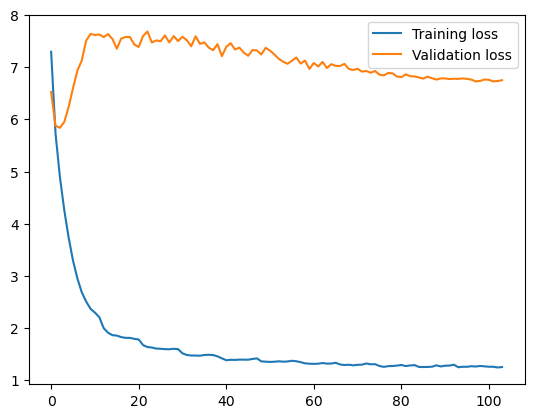

In [32]:
pd.Series(training_loss).to_csv("/kaggle/working/VQA/training_loss.csv", index=False)
pd.Series(validation_loss).to_csv("/kaggle/working/VQA/validation_loss.csv", index=False)
plt.figure()
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.savefig("/kaggle/working/VQA/loss.png")

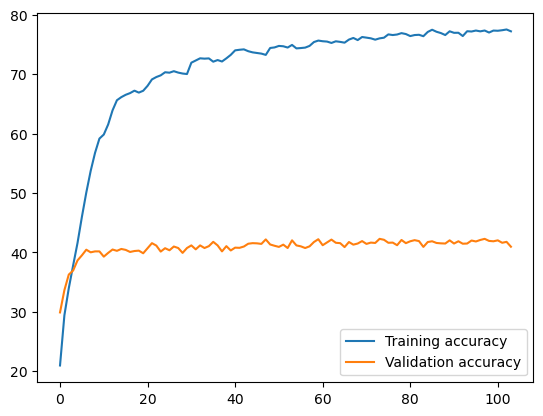

In [33]:
pd.Series(training_accuracy).to_csv("/kaggle/working/VQA/training_accuracy.csv", index=False)
pd.Series(validation_accuracy).to_csv("/kaggle/working/VQA/validation_accuracy.csv", index=False)
plt.figure()
plt.plot(training_accuracy, label="Training accuracy")
plt.plot(validation_accuracy, label="Validation accuracy")
plt.legend()
plt.savefig("/kaggle/working/VQA/accuracy.png")

#### Comments
For the answer classification model, training accuracy reaches a maximum of 77.54% while the validation accuracy reaches a maximum of 42.29%.

In [34]:
training_ans_loss, validation_ans_loss, training_ans_accuracy, validation_ans_accuracy = train_ans(
    model_ans,
    train_loader,
    val_loader,
    criterion_ans,
    optimizer_ans,
    scheduler_ans,
    num_epochs=250,
)

  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [1/250], Train Loss: 0.5490, Train Acc: 80.81%, Val Loss: 0.5464, Val Acc: 81.66%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [2/250], Train Loss: 0.5415, Train Acc: 83.23%, Val Loss: 0.5448, Val Acc: 82.98%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [3/250], Train Loss: 0.5394, Train Acc: 83.93%, Val Loss: 0.5436, Val Acc: 83.64%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [4/250], Train Loss: 0.5383, Train Acc: 84.22%, Val Loss: 0.5442, Val Acc: 83.01%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [5/250], Train Loss: 0.5371, Train Acc: 84.79%, Val Loss: 0.5439, Val Acc: 83.01%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [6/250], Train Loss: 0.5364, Train Acc: 85.04%, Val Loss: 0.5435, Val Acc: 83.04%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [7/250], Train Loss: 0.5358, Train Acc: 85.16%, Val Loss: 0.5442, Val Acc: 82.79%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [8/250], Train Loss: 0.5353, Train Acc: 85.31%, Val Loss: 0.5466, Val Acc: 82.48%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [9/250], Train Loss: 0.5349, Train Acc: 85.55%, Val Loss: 0.5446, Val Acc: 82.95%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [10/250], Train Loss: 0.5345, Train Acc: 85.66%, Val Loss: 0.5442, Val Acc: 82.89%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [11/250], Train Loss: 0.5342, Train Acc: 85.73%, Val Loss: 0.5445, Val Acc: 82.89%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [12/250], Train Loss: 0.5341, Train Acc: 85.78%, Val Loss: 0.5440, Val Acc: 82.86%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [13/250], Train Loss: 0.5336, Train Acc: 85.87%, Val Loss: 0.5444, Val Acc: 82.76%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [14/250], Train Loss: 0.5335, Train Acc: 85.84%, Val Loss: 0.5448, Val Acc: 82.92%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 8.0000e-04.



Epoch [15/250], Train Loss: 0.5332, Train Acc: 86.12%, Val Loss: 0.5448, Val Acc: 82.70%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [16/250], Train Loss: 0.5325, Train Acc: 86.41%, Val Loss: 0.5443, Val Acc: 82.79%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [17/250], Train Loss: 0.5322, Train Acc: 86.38%, Val Loss: 0.5448, Val Acc: 82.60%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [18/250], Train Loss: 0.5320, Train Acc: 86.51%, Val Loss: 0.5451, Val Acc: 82.76%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [19/250], Train Loss: 0.5320, Train Acc: 86.56%, Val Loss: 0.5453, Val Acc: 82.60%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [20/250], Train Loss: 0.5318, Train Acc: 86.58%, Val Loss: 0.5452, Val Acc: 82.73%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [21/250], Train Loss: 0.5317, Train Acc: 86.51%, Val Loss: 0.5451, Val Acc: 82.54%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [22/250], Train Loss: 0.5315, Train Acc: 86.63%, Val Loss: 0.5452, Val Acc: 82.60%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [23/250], Train Loss: 0.5314, Train Acc: 86.67%, Val Loss: 0.5452, Val Acc: 82.67%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 6.4000e-04.



Epoch [24/250], Train Loss: 0.5315, Train Acc: 86.64%, Val Loss: 0.5448, Val Acc: 82.63%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [25/250], Train Loss: 0.5307, Train Acc: 86.91%, Val Loss: 0.5455, Val Acc: 82.54%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [26/250], Train Loss: 0.5307, Train Acc: 86.88%, Val Loss: 0.5452, Val Acc: 82.70%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [27/250], Train Loss: 0.5306, Train Acc: 86.98%, Val Loss: 0.5457, Val Acc: 82.70%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [28/250], Train Loss: 0.5305, Train Acc: 86.94%, Val Loss: 0.5457, Val Acc: 82.67%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [29/250], Train Loss: 0.5304, Train Acc: 86.95%, Val Loss: 0.5466, Val Acc: 82.79%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [30/250], Train Loss: 0.5303, Train Acc: 87.15%, Val Loss: 0.5459, Val Acc: 82.60%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [31/250], Train Loss: 0.5302, Train Acc: 87.10%, Val Loss: 0.5460, Val Acc: 82.23%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch [32/250], Train Loss: 0.5303, Train Acc: 87.06%, Val Loss: 0.5463, Val Acc: 82.67%


  0%|          | 0/2375 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 5.1200e-04.



Epoch [33/250], Train Loss: 0.5302, Train Acc: 87.11%, Val Loss: 0.5457, Val Acc: 82.57%



Early stopping at epoch 33. Best Val Acc: 83.64323983611725%


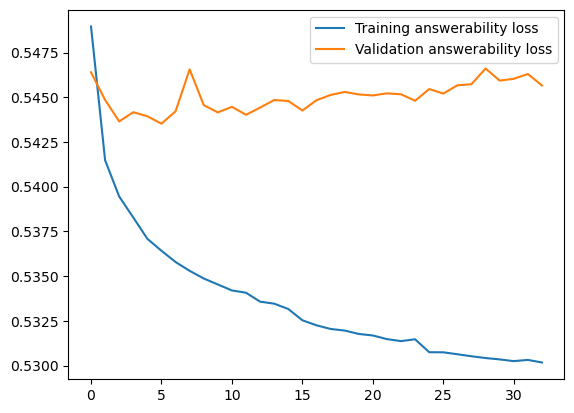

In [35]:
pd.Series(training_ans_loss).to_csv("/kaggle/working/answerability/training_loss.csv", index=False)
pd.Series(validation_ans_loss).to_csv("/kaggle/working/answerability/validation_loss.csv", index=False)
plt.figure()
plt.plot(training_ans_loss, label="Training answerability loss")
plt.plot(validation_ans_loss, label="Validation answerability loss")
plt.legend()
plt.savefig("/kaggle/working/answerability/loss.png")

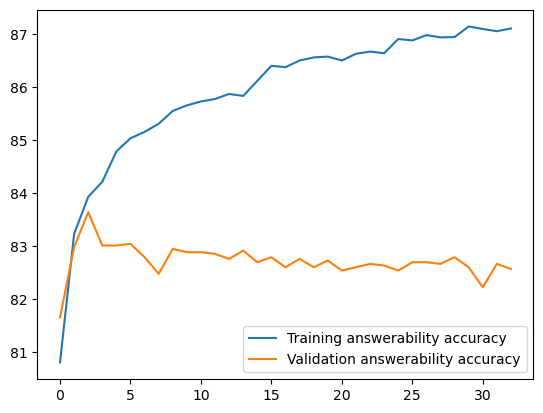

In [36]:
pd.Series(training_ans_accuracy).to_csv("/kaggle/working/answerability/training_accuracy.csv", index=False)
pd.Series(validation_ans_accuracy).to_csv("/kaggle/working/answerability/validation_accuracy.csv", index=False)
plt.figure()
plt.plot(training_ans_accuracy, label="Training answerability accuracy")
plt.plot(validation_ans_accuracy, label="Validation answerability accuracy")
plt.legend()
plt.savefig("/kaggle/working/answerability/accuracy.png")

#### Comment
For the answerability classification model, training accuracy reaches a maximum of 87.15% while the validation accuracy reaches a maximum of 83.64%.

# Testing

In [37]:
def test_vqa(model, test_loader):
    # evaluate the model on the test set
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for i, (images, questions, targets, answerable, ans_type) in enumerate(
            test_loader
        ):
            images = images.to(device)
            questions = questions.to(device)
            targets = targets.to(device)
            answerable = answerable.to(device)
            ans_type = ans_type.to(device)

            # forward pass
            outputs, aux = model(images, questions)

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()
    test_accuracy = 100 * test_correct / test_total
    print(f"VQA Test Acc: {test_accuracy}%")

    return test_accuracy


def test_ans(model, test_loader):
    # evaluate the model on the test set
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for i, (images, questions, targets, answerable, ans_type) in enumerate(
            test_loader
        ):
            images = images.to(device)
            questions = questions.to(device)
            targets = targets.to(device)
            answerable = answerable.to(device)
            ans_type = ans_type.to(device)

            # forward pass
            ans = model(images, questions)

            # calculate accuracy
            predicted = ans >= 0.5
            test_total += answerable.size(0)
            test_correct += (predicted == answerable.float()).sum().item()
    test_accuracy = 100 * test_correct / test_total
    print(f"Answerability Test Acc: {test_accuracy}%")

    return test_accuracy

In [38]:
# create the model
model_vqa = VQA()
model_vqa = model_vqa.to(device)
checkpoint_vqa = torch.load(f"{checkpoint_path}VQA/checkpoint.pth")
model_vqa, _, _, _ = load_checkpoint(model_vqa, optimizer_vqa, checkpoint_vqa)

model_ans = Linear_ans()
model_ans = model_ans.to(device)
checkpoint_ans = torch.load(f"{checkpoint_path}answerability/checkpoint.pth")
model_ans, _, _, _ = load_checkpoint(model_ans, optimizer_ans, checkpoint_ans)

In [39]:
vqa_test_acc = test_vqa(model_vqa, test_loader)

VQA Test Acc: 42.0%


In [40]:
ans_test_acc = test_ans(model_ans, test_loader)

Answerability Test Acc: 82.8%


## Comment
For the answer classification, we get a 42.0% testing accuracy compared to the paper's 60.7%. However, it is likely that the paper used a different accuracy scoring measure.
Meanwhile for the answerability binary classification, our model's testing accuracy reaches 82.8% comparable to the paper's 83.5%.

# Bonus: Evaluation on unseen pairs of question-image

In [15]:
class EvaluationDataSet(Dataset):
    def __init__(self, image_path, df):
        self.image_path = image_path
        self.df = df
        # clip model
        self.model, self.preprocess = clip.load("ViT-L/14@336px", device="cuda")

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path=self.image_path+self.df.iloc[idx]['image']
        image = Image.open(img_path)
        image = TF.pil_to_tensor(TF.resize(image, (336, 336)))
        image=to_pil_image(image[0])
        question = self.df.iloc[idx]['question']
        # preprocess image
        image_input = self.preprocess(image).unsqueeze(0).to(device)
        # encode text
        text_input = clip.tokenize(question).to(device)
        with torch.no_grad():
            image_features = self.model.encode_image(image_input)
        with torch.no_grad():
            text_features = self.model.encode_text(text_input)
        image_features = torch.squeeze(image_features)
        text_features = torch.squeeze(text_features)
        return img_path, question, image_features, text_features
    

def evaluate_model(model_vqa,model_ans,evaluation_loader,class_mapping):
    model_ans.eval()
    with torch.no_grad():
        for i, (img_path,question, image_features, text_features) in enumerate(evaluation_loader):
            image_features = image_features.to(device)
            text_features = text_features.to(device)
#             print(image_features.dtype)
#             print(text_features.dtype)
            image_features = image_features.to(text_features.dtype)
            ans = model_ans(image_features.float(), text_features.float())
#             print(outputs)
            predicted = ans.data >= 0.5
#             predicted=predicted.item()
#             print("Predicted",predicted)
            image = Image.open(img_path[0])
            plt.imshow(image)
            print(img_path)
            plt.axis('off')
            plt.show()
            print(f"Question: {question}")
            print(f"Answerable: {'Yes' if predicted.item() else 'No'}")            
            model_vqa.eval()
            with torch.no_grad():
#                 image_features = image_features.to(device)
#                 text_features = text_features.to(device)
                outputs, aux  = model_vqa(image_features.float(), text_features.float())
                _, predicted = torch.max(outputs.data, 1)
                print(f"Answer: {class_mapping[predicted.item()]}")

            

In [10]:
checkpoint_path="/kaggle/input/clip-vqa-output/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Evaluation on test dataset

('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020000.jpg',)


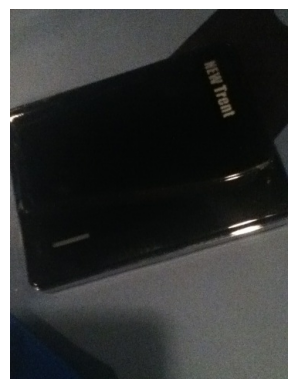

Question: ('What is this? And what color is it?',)
Answerable: Yes
Answer: black
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020001.jpg',)


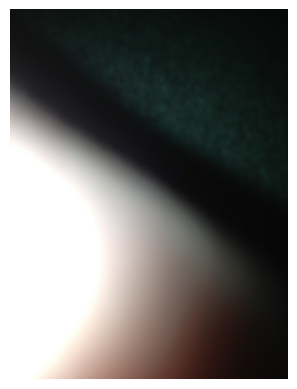

Question: ('What is this?',)
Answerable: No
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020003.jpg',)


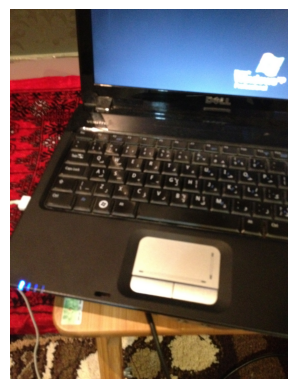

Question: ('What is this?',)
Answerable: Yes
Answer: laptop
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020004.jpg',)


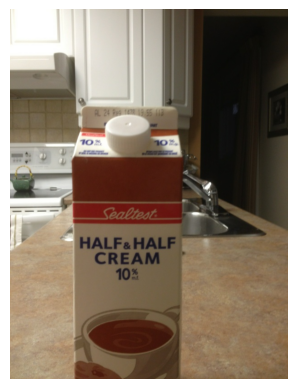

Question: ('What is this?',)
Answerable: Yes
Answer: half half
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020005.jpg',)


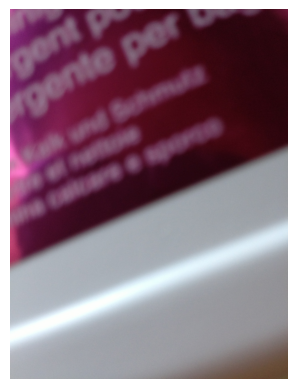

Question: ('What kind of key is this?',)
Answerable: No
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020007.jpg',)


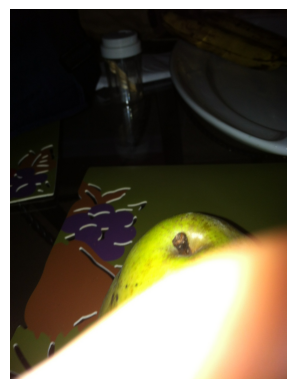

Question: ('What is this? ',)
Answerable: Yes
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000020008.jpg',)


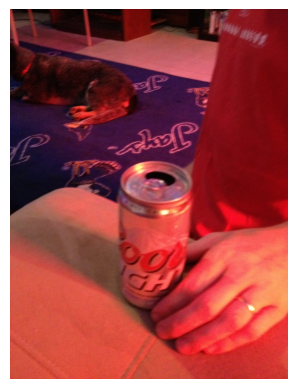

Question: ('What is this? What is this? ',)
Answerable: Yes
Answer: beer
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027976.jpg',)


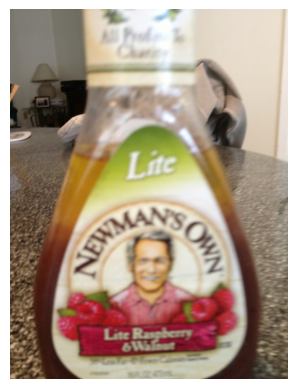

Question: ('What is this?',)
Answerable: Yes
Answer: salad dressing
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027977.jpg',)


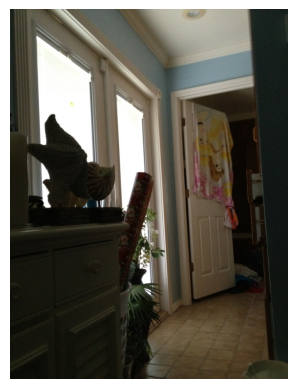

Question: ('What is this product?',)
Answerable: No
Answer: unanswerable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027978.jpg',)


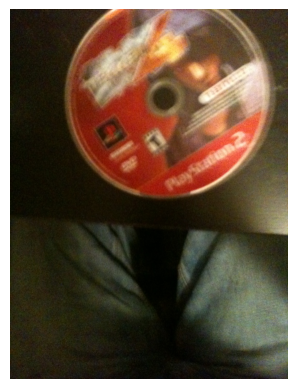

Question: ('What does this label say?',)
Answerable: No
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027983.jpg',)


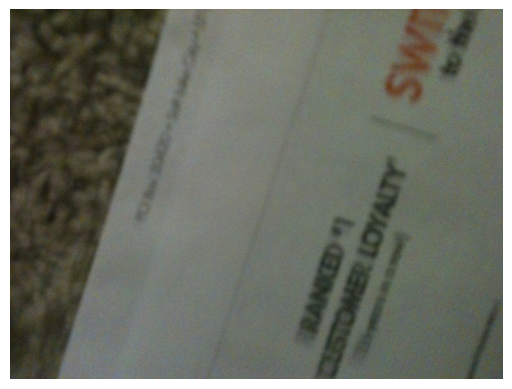

Question: ('What is this?',)
Answerable: Yes
Answer: paper
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027986.jpg',)


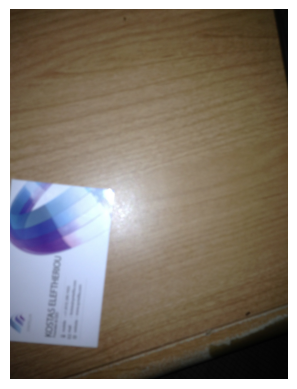

Question: ('Please read the contact information from this business card.',)
Answerable: No
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027987.jpg',)


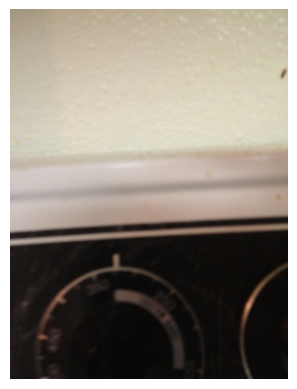

Question: ('What is the oven temperature setting?',)
Answerable: No
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027933.jpg',)


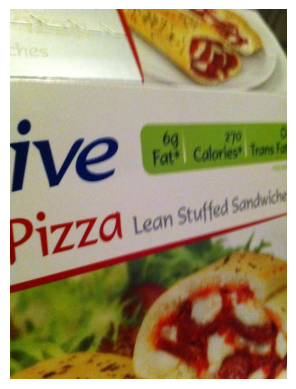

Question: ('What is this?',)
Answerable: Yes
Answer: lean cuisine french bread cheese pizza
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027934.jpg',)


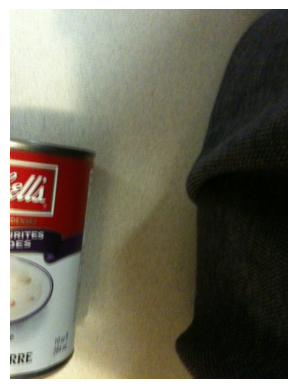

Question: ('What is in this can?',)
Answerable: Yes
Answer: soup
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027935.jpg',)


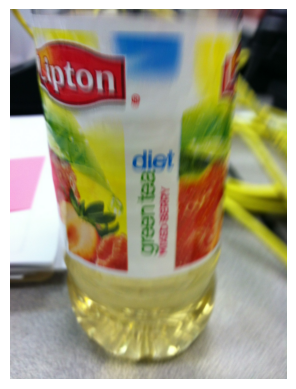

Question: ('Is there caffeine in this?',)
Answerable: Yes
Answer: yes
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027936.jpg',)


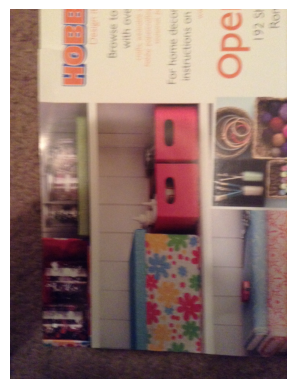

Question: ('What does this say?',)
Answerable: Yes
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027939.jpg',)


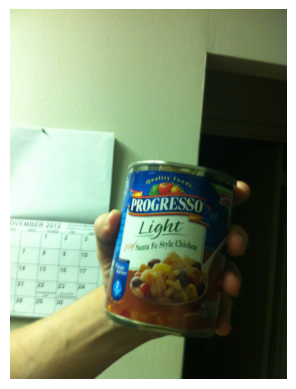

Question: ('What flavor of soup is this?',)
Answerable: Yes
Answer: chicken noodle
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027942.jpg',)


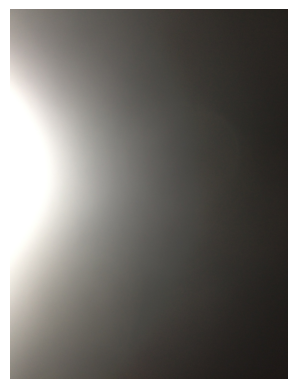

Question: ('What is this picture frame?',)
Answerable: No
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027943.jpg',)


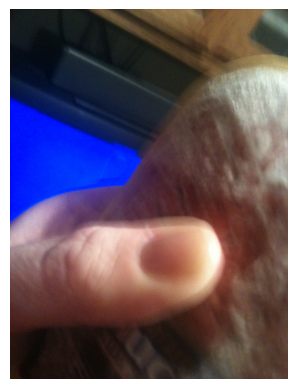

Question: ('What is in this package?',)
Answerable: No
Answer: unsuitable
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027944.jpg',)


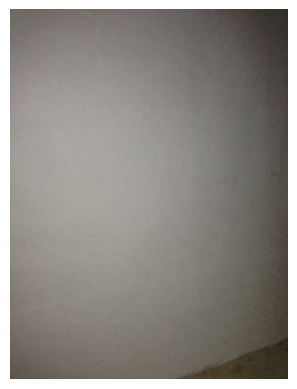

Question: ('What color is it?',)
Answerable: Yes
Answer: grey
('/kaggle/input/vizwiz/data/Images/VizWiz_test_000000027906.jpg',)


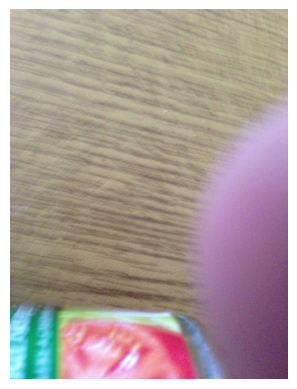

Question: ('Is the product more in focus now so the expiration date is visible?',)
Answerable: No
Answer: unsuitable


In [16]:
# load the model
model_vqa = VQA()
model_vqa = model_vqa.to(device)
checkpoint_vqa = torch.load(f"{checkpoint_path}VQA/checkpoint.pth")
model_vqa, _, _, _ = load_checkpoint(model_vqa, optimizer_vqa, checkpoint_vqa)

model_ans = Linear_ans()
model_ans = model_ans.to(device)
checkpoint_ans = torch.load(f"{checkpoint_path}answerability/checkpoint.pth")
model_ans, _, _, _ = load_checkpoint(model_ans, optimizer_ans, checkpoint_ans)
IMAGES_PATH = "/kaggle/input/vizwiz/data/Images/"
# load the evaluation dataset
evaluation_df = pd.DataFrame(json.load(open("/kaggle/input/evaluation/evaluation.json")))
evaluation_dataset = EvaluationDataSet(IMAGES_PATH, evaluation_df)
evaluation_loader = DataLoader(evaluation_dataset, batch_size=1, shuffle=False)
class_mapping = pd.read_csv("/kaggle/input/clip-vqa-output/class_mapping.csv")
# change to a dict
class_mapping = dict(zip(class_mapping['class_id'], class_mapping['answer']))
# evaluate the model
evaluate_model(model_vqa,model_ans,evaluation_loader,class_mapping)


## Evaluation on pictures we took

('/kaggle/input/our-pictures/img1.jpg',)


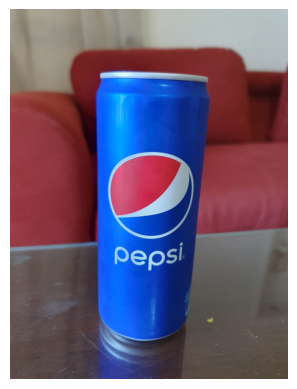

Question: ('what is this?',)
Answerable: Yes
Answer: pepsi
('/kaggle/input/our-pictures/img2.jpg',)


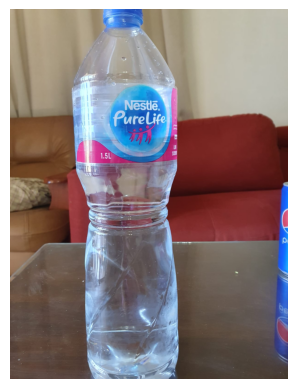

Question: ('What is this',)
Answerable: Yes
Answer: water bottle
('/kaggle/input/our-pictures/img3.jpg',)


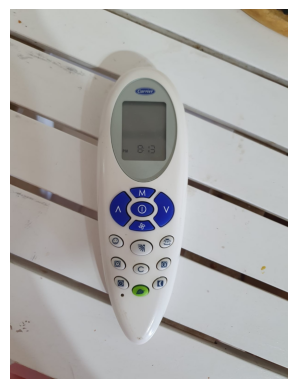

Question: ('what is this?',)
Answerable: Yes
Answer: remote
('/kaggle/input/our-pictures/img4.jpg',)


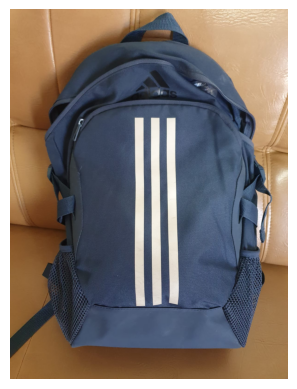

Question: ('what is this?',)
Answerable: Yes
Answer: backpack
('/kaggle/input/our-pictures/img5.jpg',)


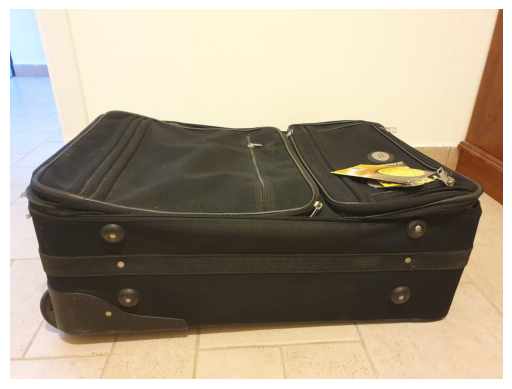

Question: ('what color is this',)
Answerable: Yes
Answer: black
('/kaggle/input/our-pictures/img6.jpg',)


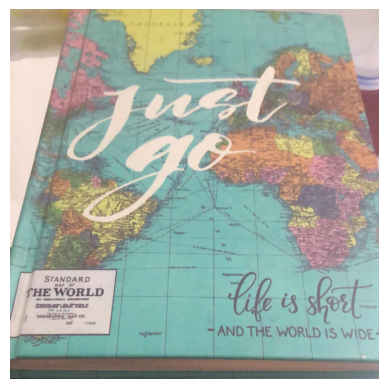

Question: ('what is this',)
Answerable: Yes
Answer: book
('/kaggle/input/our-pictures/img7.jpg',)


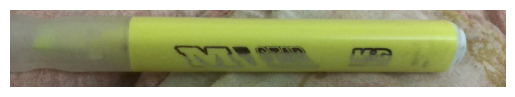

Question: ('what is this',)
Answerable: No
Answer: unanswerable
('/kaggle/input/our-pictures/img8.jpg',)


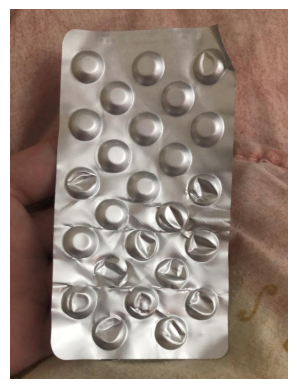

Question: ('what is this',)
Answerable: No
Answer: pills
('/kaggle/input/our-pictures/img9.jpg',)


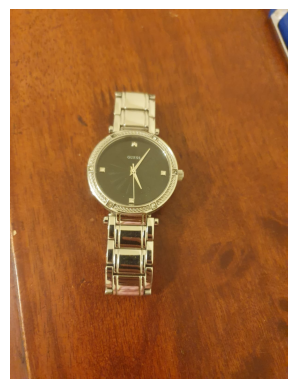

Question: ('what is this?',)
Answerable: Yes
Answer: watch
('/kaggle/input/our-pictures/img10.jpg',)


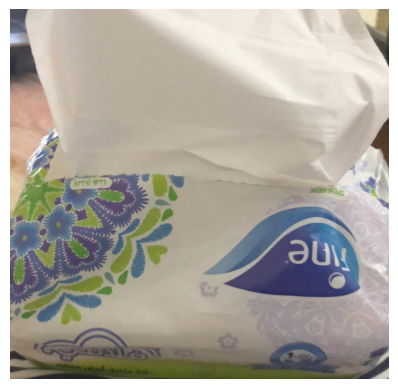

Question: ('what is this?',)
Answerable: Yes
Answer: kleenex


In [25]:
# load the model
model_vqa = VQA()
model_vqa = model_vqa.to(device)
checkpoint_vqa = torch.load(f"{checkpoint_path}VQA/checkpoint.pth")
model_vqa, _, _, _ = load_checkpoint(model_vqa, optimizer_vqa, checkpoint_vqa)

model_ans = Linear_ans()
model_ans = model_ans.to(device)
checkpoint_ans = torch.load(f"{checkpoint_path}answerability/checkpoint.pth")
model_ans, _, _, _ = load_checkpoint(model_ans, optimizer_ans, checkpoint_ans)
IMAGES_PATH = "/kaggle/input/our-pictures/"

# load the evaluation dataset
evaluation_df = pd.DataFrame(json.load(open("/kaggle/input/our-pictures/our_pictures.json")))
evaluation_dataset = EvaluationDataSet(IMAGES_PATH, evaluation_df)
evaluation_loader = DataLoader(evaluation_dataset, batch_size=1, shuffle=False)
class_mapping = pd.read_csv("/kaggle/input/clip-vqa-output/class_mapping.csv")
# change to a dict
class_mapping = dict(zip(class_mapping['class_id'], class_mapping['answer']))
# evaluate the model
evaluate_model(model_vqa,model_ans,evaluation_loader,class_mapping)
